In [1]:
COUNT = 600
TRAIN = '/kaggle/input/american-sign-language-silhouettes/gestures'

We want to use image embeddings for EDA and classification, so let's add some code that will get them using ResNeXt with no fine tuning.

In [2]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np


DEVICE = torch.device('cpu')
OUTPUT_SIZE = 2048

model = models.resnext50_32x4d(weights=models.ResNeXt50_32X4D_Weights.IMAGENET1K_V2)

extraction_layer = model._modules.get('avgpool')
model.to(DEVICE)
model.eval()

scaler = transforms.Resize((224, 224))
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
to_tensor = transforms.ToTensor()

def get_vec(arg, model, extraction_layer):
    image = normalize(to_tensor(scaler(arg))).unsqueeze(0).to(DEVICE)
    result = torch.zeros(1, OUTPUT_SIZE, 1, 1)
    def copy_data(m, i, o):
        result.copy_(o.data)
    hooked = extraction_layer.register_forward_hook(copy_data)
    with torch.no_grad():
        model(image)
    hooked.remove()
    return result

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-1a0047aa.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-1a0047aa.pth
100%|██████████| 95.8M/95.8M [00:00<00:00, 165MB/s]


Next let's load up a sample of our data. We have a lot of classes, so let's take a relatively small sample of each class.

In [3]:
import arrow
import base64
import pandas as pd
from glob import iglob
from io import BytesIO
from os.path import basename
from PIL import Image

THUMBNAIL_SIZE = (64, 64)

def embed(model, filename: str):
    with Image.open(fp=filename, mode='r') as image:
        return get_vec(arg=image.convert('RGB'), model=model, extraction_layer=extraction_layer).numpy().reshape(OUTPUT_SIZE,)


# https://stackoverflow.com/a/952952
def flatten(arg):
    return [x for xs in arg for x in xs]

def png(filename: str) -> str:
    with Image.open(fp=filename, mode='r') as image:
        buffer = BytesIO()
        # our images are pretty big; let's shrink the hover images to thumbnail size
        image.resize(size=THUMBNAIL_SIZE).convert('RGB').save(buffer, format='png')
        return 'data:image/png;base64,' + base64.b64encode(buffer.getvalue()).decode()

def get_picture_from_glob(arg: str, tag: str,) -> list:
    time_get = arrow.now()
    result = [pd.Series(data=[tag, basename(input_file), embed(model=model, filename=input_file), png(filename=input_file)],
                        index=['tag', 'name', 'value', 'png'] )
        for index, input_file in enumerate(list(iglob(pathname=arg))) if index < COUNT]
    print('encoded {} rows of {}  in {}'.format(len(result), tag, arrow.now() - time_get))
    return result

time_start = arrow.now()
train_dict = {basename(folder) : folder + '/*.*' for folder in iglob(TRAIN + '/*') }
train_df = pd.DataFrame(data=flatten(arg=[get_picture_from_glob(arg=value, tag=key) for key, value in train_dict.items()]))
print('done in {}'.format(arrow.now() - time_start))

encoded 600 rows of 7  in 0:01:24.569906
encoded 600 rows of 17  in 0:01:24.127084
encoded 600 rows of 19  in 0:01:24.410082
encoded 600 rows of 22  in 0:01:25.173887
encoded 600 rows of 2  in 0:01:23.920338
encoded 600 rows of 23  in 0:01:23.143164
encoded 600 rows of 10  in 0:01:22.982936
encoded 600 rows of 5  in 0:01:24.110284
encoded 600 rows of 20  in 0:01:23.898380
encoded 600 rows of 25  in 0:01:23.515199
encoded 600 rows of 8  in 0:01:24.573298
encoded 600 rows of 12  in 0:01:25.145851
encoded 600 rows of 0  in 0:01:25.090676
encoded 600 rows of 18  in 0:01:26.448830
encoded 600 rows of 16  in 0:01:26.973103
encoded 600 rows of 13  in 0:01:27.518054
encoded 600 rows of 26  in 0:01:25.990138
encoded 600 rows of 15  in 0:01:27.891121
encoded 600 rows of 3  in 0:01:26.278054
encoded 600 rows of 1  in 0:01:25.698735
encoded 600 rows of 14  in 0:01:25.505728
encoded 600 rows of 4  in 0:01:25.549898
encoded 600 rows of 9  in 0:01:25.776700
encoded 600 rows of 21  in 0:01:23.598473
e

Next let's add x/y coordinates using TSNE.

In [4]:
from sklearn.manifold import TSNE

train_reducer = TSNE(random_state=2025, verbose=True, n_jobs=1, perplexity=20.0, init='pca')
train_df[['x', 'y']] = train_reducer.fit_transform(X=train_df['value'].apply(func=pd.Series))

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 16200 samples in 0.098s...
[t-SNE] Computed neighbors for 16200 samples in 21.272s...
[t-SNE] Computed conditional probabilities for sample 1000 / 16200
[t-SNE] Computed conditional probabilities for sample 2000 / 16200
[t-SNE] Computed conditional probabilities for sample 3000 / 16200
[t-SNE] Computed conditional probabilities for sample 4000 / 16200
[t-SNE] Computed conditional probabilities for sample 5000 / 16200
[t-SNE] Computed conditional probabilities for sample 6000 / 16200
[t-SNE] Computed conditional probabilities for sample 7000 / 16200
[t-SNE] Computed conditional probabilities for sample 8000 / 16200
[t-SNE] Computed conditional probabilities for sample 9000 / 16200
[t-SNE] Computed conditional probabilities for sample 10000 / 16200
[t-SNE] Computed conditional probabilities for sample 11000 / 16200
[t-SNE] Computed conditional probabilities for sample 12000 / 16200
[t-SNE] Computed conditional probabilities for sa

Now we're ready to plot.

In [5]:
from bokeh.models import ColumnDataSource
from bokeh.models import HoverTool

from bokeh.plotting import figure
from bokeh.plotting import output_notebook
from bokeh.plotting import show
from bokeh.palettes import Turbo256
from bokeh.transform import factor_cmap

output_notebook()

datasource = ColumnDataSource(train_df[['png', 'tag', 'x', 'y']].sample(n=2000, random_state=2025))
factor_count = max(train_df['tag'].nunique(), 3)
indices = np.linspace(0, len(Turbo256)-1, factor_count, dtype=int)
palette = [Turbo256[index] for index in indices]
mapper = factor_cmap(field_name = 'tag', palette=palette, factors=train_df['tag'].unique().tolist(), start=0, end=factor_count-1, )

plot_figure = figure(title='TSNE projection: ASL silhouettes', width=1000, height=800, tools=('pan, wheel_zoom, reset'))

plot_figure.add_tools(HoverTool(tooltips="""
<div>
    <div>
        <img src='@png' style='float: left; margin: 5px 5px 5px 5px'/>
    </div>
    <div>
        <span style='font-size: 18px'>@tag</span>
    </div>
</div>
"""))

plot_figure.scatter(x='x', y='y', source=datasource, line_alpha=0.6, fill_alpha=0.6, size=6, color=mapper)
show(plot_figure)

Loading BokehJS ...

What do we see? Surprisingly, most of our classes are in tight, distinct clusters. We should be optimistic about our model accuracy. Let's build a model and see what we get.

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_df['value'].apply(pd.Series), train_df['tag'], test_size=0.25, random_state=2025, stratify=train_df['tag'])
logreg = LogisticRegression(max_iter=5000, tol=1e-12).fit(X_train, y_train)
print('model fit in {} iterations'.format(logreg.n_iter_[0]))
print('accuracy: {:5.4f}'.format(accuracy_score(y_true=y_test, y_pred=logreg.predict(X=X_test))))
print('f1: {:5.4f}'.format(f1_score(average='weighted', y_true=y_test, y_pred=logreg.predict(X=X_test))))
print(classification_report(y_true=y_test, y_pred=logreg.predict(X=X_test)))

model fit in 957 iterations
accuracy: 0.9990
f1: 0.9990
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       150
           1       1.00      0.99      1.00       150
          10       1.00      1.00      1.00       150
          11       0.99      1.00      1.00       150
          12       1.00      1.00      1.00       150
          13       1.00      0.99      1.00       150
          14       1.00      1.00      1.00       150
          15       1.00      1.00      1.00       150
          16       1.00      1.00      1.00       150
          17       1.00      1.00      1.00       150
          18       1.00      1.00      1.00       150
          19       1.00      1.00      1.00       150
           2       1.00      1.00      1.00       150
          20       1.00      0.99      1.00       150
          21       0.99      1.00      1.00       150
          22       1.00      0.99      1.00       150
          23       1.00  

An f1 greater than 0.98 for almost no effort is kind of surprising. Let's take a look at our model probabilities.

<Axes: xlabel='probability', ylabel='Count'>

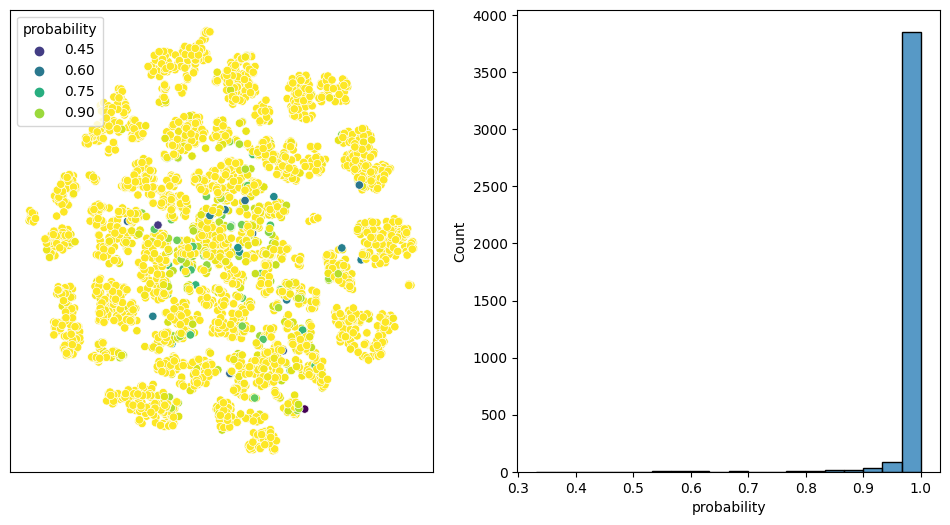

In [7]:
import matplotlib.pyplot as plt
import warnings
from seaborn import histplot
from seaborn import scatterplot

warnings.filterwarnings('ignore', category=FutureWarning, module='seaborn')

plot_df = train_df.iloc[X_test.index][['x', 'y']].copy()
plot_df['probability'] = np.max(logreg.predict_proba(X=X_test), axis=1)

plt, ax = plt.subplots(ncols=2, figsize=(12, 6))
scatterplot(ax=ax[0], data=plot_df, x='x', y='y', hue='probability', palette='viridis')
ax[0].set(xlabel=None) 
ax[0].set(ylabel=None)
ax[0].set(xticklabels=[])
ax[0].set(yticklabels=[])
ax[0].tick_params(axis='both', which='both', length=0)
histplot(ax=ax[1], data=plot_df, x='probability', bins=20)

Our model probabilities are mostly quite high, except for the overlapping TSNE clusters.